In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
print(f'Train -> x: {x_train.shape}')
print(f'         y: {y_train.shape}')
print(f'Test -> x: {x_test.shape}')
print(f'        y: {y_test.shape}')

11493376/11490434 [==============================] - 6s 1us/step
Train -> x: (60000, 28, 28)
         y: (60000,)
Test -> x: (10000, 28, 28)
        y: (10000,)


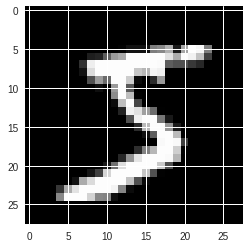

In [3]:
plt.imshow(x_train[0], 'gray');

In [4]:
# Ajustamos las dimensiones de las imágenes
x_train = x_train[..., None]
x_test = x_test[..., None]
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [118]:
# Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD

lr = 0.01
bs = 256
nb = math.ceil(len(x_train)/bs) # Nro de batches

model = Sequential([
    Conv2D(32, 3, activation='relu', padding='same', input_shape=(28,28,1)),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax')
])

model.compile(SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1152)              0         
__________

In [119]:
# Trainning
log = model.fit(x_train, y_train, batch_size=bs, epochs=6, validation_data=[x_test, y_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 7s 123us/step - loss: 1.1607 - acc: 0.6989 - val_loss: 0.4630 - val_acc: 0.8361
Epoch 2/6
60000/60000 [==============================] - 5s 84us/step - loss: 0.2784 - acc: 0.9186 - val_loss: 0.2192 - val_acc: 0.9359
Epoch 3/6
60000/60000 [==============================] - 5s 84us/step - loss: 0.1818 - acc: 0.9463 - val_loss: 0.1567 - val_acc: 0.9496
Epoch 4/6
60000/60000 [==============================] - 5s 84us/step - loss: 0.1399 - acc: 0.9584 - val_loss: 0.1124 - val_acc: 0.9667
Epoch 5/6
60000/60000 [==============================] - 5s 84us/step - loss: 0.1175 - acc: 0.9647 - val_loss: 0.1155 - val_acc: 0.9638
Epoch 6/6
60000/60000 [==============================] - 5s 84us/step - loss: 0.1028 - acc: 0.9688 - val_loss: 0.2114 - val_acc: 0.9259


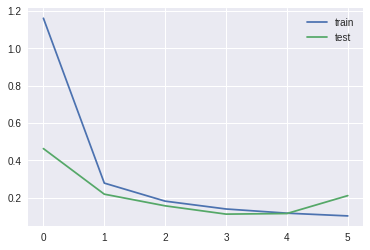

In [120]:
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='test')
plt.legend();

# Extra

## Utils

In [0]:
import keras, math
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
from pathlib import Path

def show_results(model, log, cycling=False):
    loss, acc = model.evaluate(x_test, y_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log.history['val_loss']
    val_acc = log.history['val_acc']
    if cycling:
        val_loss += [loss]
        val_acc += [acc]
        
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['acc'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias'):
            if layer.bias and hasattr(layer, 'bias_initializer'): layer.bias.initializer.run(session=session)

class CycleLearner(keras.callbacks.Callback):
    def __init__(self, lr, nb, n_cycle, cycle_len=1, cycle_mult=1,
                 snapshots=False, n_snapshots=5,
                 snapshots_name='temp_model', snapshots_folder='snapshots'):
        super().__init__()
        self.lr = lr
        self.nb = nb*cycle_len
        self.n_cycle = n_cycle
        self.cycle_len = cycle_len
        self.cycle_mult = cycle_mult
        self.snapshots = snapshots
        self.n_snapshots = n_snapshots
        self.start_snaps = n_cycle - n_snapshots
        self.snapshots_name = snapshots_name
        self.snapshots_folder = Path(snapshots_folder)
        self.lr_log = []
        self.losses = []
        self.iterations = []
        if snapshots: self.snapshots_folder.mkdir(exist_ok=True)

    def on_train_begin(self, logs={}):
        self.iteration,self.epoch = 0,0
        self.cycle_iter,self.cycle_count=0,0
        self.update_lr()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_log.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)
        self.update_lr()
        if self.cycle_count == self.n_cycle:
            self.model.stop_training = True
    
    def on_cycle_end(self):
        self.cycle_iter = 0
        self.nb *= self.cycle_mult
        self.cycle_count += 1
        if self.snapshots and self.cycle_count>self.start_snaps:
            file = self.snapshots_folder / f'{self.snapshots_name}_{self.cycle_count}.hdf5'
            self.model.save_weights(file, overwrite=True)
    
    def update_lr(self):
        new_lr = self.calc_lr()
        K.set_value(self.model.optimizer.lr, new_lr)

    def calc_lr(self):
        if self.iteration<self.nb/20:
            self.cycle_iter += 1
            return self.lr/100.

        cos_out = np.cos(np.pi*(self.cycle_iter)/self.nb) + 1
        self.cycle_iter += 1
        if self.cycle_iter==self.nb:
            self.on_cycle_end()
            
        return self.lr / 2 * cos_out        
        
    def plot_loss(self, skip=10):
        plt.plot(self.iterations[skip:], self.losses[skip:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_log)


class LrFinder(keras.callbacks.Callback):
    def __init__(self, nb, start_lr=1e-5, end_lr=10):
        super().__init__()
        self.start_lr = start_lr
        self.lr = start_lr
        self.lr_mult = (end_lr/start_lr)**(1/nb)
        self.lr_log = []
        self.losses = []
        self.iterations = []
        
    def on_train_begin(self, logs={}):
        self.best = 1e9
        self.iteration = 0
        self.update_lr()

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_log.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)

        if math.isnan(loss) or loss>self.best*4:
            self.model.stop_training = True
        if loss<self.best:
            self.best=loss
        self.update_lr()
    
    def update_lr(self):
        new_lr = self.start_lr * (self.lr_mult**self.iteration)
        K.set_value(self.model.optimizer.lr, new_lr)
        
    def plot_loss(self):
        plt.plot(self.iterations[10:], self.losses[10:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_log)
        
    def plot(self, n_skip_start=2, xlim=None, ylim=None):
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lr_log[n_skip_start:], self.losses[n_skip_start:])
        plt.xscale('log')
        if ylim is not None: plt.ylim(top=ylim)
        if xlim is not None: plt.xlim(right=xlim)
        

## Model

In [128]:
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten,
GlobalAvgPool2D, GlobalMaxPool2D, Dropout, BatchNormalization,
concatenate, Layer, Input
from keras.regularizers import l2
from keras.optimizers import SGD

lr = 0.01
bs = 256
nb = math.ceil(len(x_train)/bs) # Nro de batches
l2_w = 1e-4

model_in = Input((28,28,1))

x = model_in
for k in [32, 64, 128]:
  x = Conv2D(k, 3, strides=2, activation='relu', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(l2_w))(x)
  x = BatchNormalization()(x)

x_avg = GlobalAvgPool2D()(x)
x_max = GlobalMaxPool2D()(x)
x = concatenate([x_avg, x_max])
x = Dropout(0.25)(x)

model_out = Dense(10, activation='softmax', kernel_regularizer=l2(l2_w))(x)

model = Model(model_in, model_out)

model.compile(SGD(lr, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 13, 13, 32)   288         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 13, 13, 32)   128         conv2d_136[0][0]                 
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 6, 6, 64)     18432       batch_normalization_103[0][0]    
__________________________________________________________________________________________________
batch_norm

Epoch 1/1
 2816/60000 [>.............................] - ETA: 24s - loss: 3.5080 - acc: 0.0952

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157137). Check your callbacks.
  % delta_t_median)


49664/60000 [=======================>......] - ETA: 1s - loss: 1.8092 - acc: 0.4963

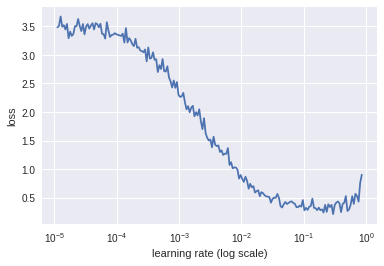

In [129]:
lr_finder = LrFinder(nb)
model.fit(x_train, y_train, batch_size=bs, callbacks=[lr_finder])
lr_finder.plot()

In [0]:
lr = 2e-2
model.compile(SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [133]:
reset_weights(model)
cycle_learner = CycleLearner(lr, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100, validation_data=[x_test, y_test], callbacks=[cycle_learner])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 2816/60000 [>.............................] - ETA: 24s - loss: 3.2786 - acc: 0.0987

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164152). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 7s 110us/step - loss: 1.0055 - acc: 0.7037 - val_loss: 0.4973 - val_acc: 0.8733
Epoch 2/100
60000/60000 [==============================] - 5s 88us/step - loss: 0.4393 - acc: 0.8794 - val_loss: 0.2704 - val_acc: 0.9343
Epoch 3/100
60000/60000 [==============================] - 5s 88us/step - loss: 0.3329 - acc: 0.9129 - val_loss: 0.2519 - val_acc: 0.9400
Epoch 4/100
60000/60000 [==============================] - 5s 88us/step - loss: 0.2863 - acc: 0.9268 - val_loss: 0.1986 - val_acc: 0.9536
Epoch 5/100
60000/60000 [==============================] - 5s 89us/step - loss: 0.2368 - acc: 0.9419 - val_loss: 0.1774 - val_acc: 0.9588
Epoch 6/100
60000/60000 [==============================] - 5s 87us/step - loss: 0.2157 - acc: 0.9468 - val_loss: 0.1698 - val_acc: 0.9615
Epoch 7/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.2083 - acc: 0.9481

Loss     = 0.1686
Accuracy = 0.9612


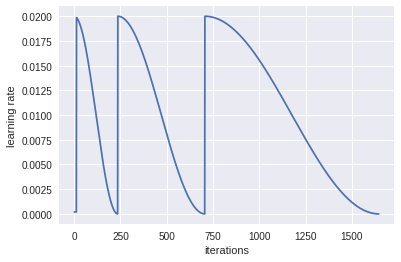

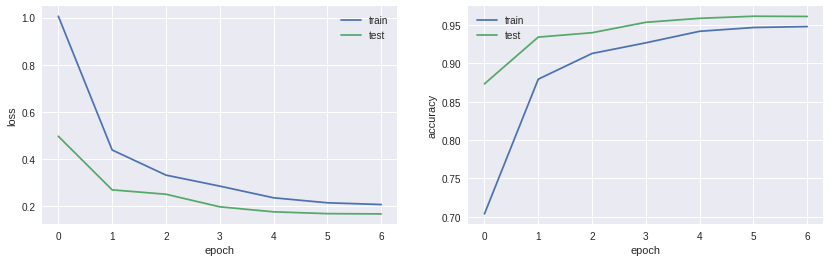

In [134]:
cycle_learner.plot_lr()
show_results(model, log, cycling=True)